 # XGBoost Demand-Forecast Model

In [180]:
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

## Load Data

In [160]:
with open('../resources/2_dataframes.pkl', 'rb') as f:
    dataframes = pickle.load(f)

In [161]:
df_holiday_events = dataframes['df_holiday_events']
df_items = dataframes['df_items']
df_oil = dataframes['df_oil']
df_stores = dataframes['df_stores']
df_transactions = dataframes['df_transactions']
df_train = dataframes['df_train']

## DType Conversions

In [162]:
df_train['onpromotion'] = df_train['onpromotion'].astype(bool)

## Filtering

In the preparation step we filtered for the top 3 item families (`GROCERY I`, `BEVERAGES`, `CLEANING`).

Additionally, we clamp the calendar window from *Jan 1 - Mar 31. 2014*.


In [163]:
min_date = '2014-01-01'
max_date = '2014-04-01'

#df_train = df_train[(df_train['date'] >= min_date) & (df_train['date'] < max_date)]
df_train = df_train[(df_train['date'] < max_date)]

## Feature Engineering

### Add Store Metadata

In [164]:
df_train = df_train.merge(df_stores[['store_nbr', 'city', 'type', 'cluster']], how='left', on='store_nbr')

### Add Item Metadata

In [165]:
df_train = df_train.merge(df_items[['item_nbr', 'family', 'class']], how='left', on='item_nbr')

In [166]:
df_train

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,rolling_mean_7d,rolling_mean_14d,lag_1d,lag_7d,lag_30d,city,type,cluster,family,class
0,2013-01-09,302230,24,96995,2.0,False,2013,1,9,2,2.000000,2.000000,NaN,NaN,NaN,Guayaquil,D,1,GROCERY I,1093
1,2013-01-10,0,24,96995,0.0,False,2013,1,10,3,1.000000,1.000000,2.0,NaN,NaN,Guayaquil,D,1,GROCERY I,1093
2,2013-01-11,0,24,96995,0.0,False,2013,1,11,4,0.666667,0.666667,0.0,NaN,NaN,Guayaquil,D,1,GROCERY I,1093
3,2013-01-12,419989,24,96995,2.0,False,2013,1,12,5,1.000000,1.000000,0.0,NaN,NaN,Guayaquil,D,1,GROCERY I,1093
4,2013-01-13,0,24,96995,0.0,False,2013,1,13,6,0.800000,0.800000,2.0,NaN,NaN,Guayaquil,D,1,GROCERY I,1093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4155310,2014-03-27,21391405,51,1466049,2.0,False,2014,3,27,3,5.428571,3.071429,4.0,5.0,0.0,Guayaquil,A,17,BEVERAGES,1114
4155311,2014-03-28,21454795,51,1466049,3.0,False,2014,3,28,4,5.000000,3.285714,2.0,6.0,0.0,Guayaquil,A,17,BEVERAGES,1114
4155312,2014-03-29,21523583,51,1466049,2.0,False,2014,3,29,5,4.285714,3.428571,3.0,7.0,0.0,Guayaquil,A,17,BEVERAGES,1114
4155313,2014-03-30,21591094,51,1466049,5.0,False,2014,3,30,6,4.142857,3.785714,2.0,6.0,0.0,Guayaquil,A,17,BEVERAGES,1114


## Train-Test Split

Chronological split: Training on data from Jan-Feb, testing on March.

In [167]:
# Define features for XGBoost
df_xgboost = df_train[['date', 'id', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'year', 'month', 'day', 'day_of_week', 'rolling_mean_7d', 'rolling_mean_14d', 'lag_1d', 'lag_7d', 'lag_30d', 'class', 'cluster']]

In [168]:
df_split_train = df_xgboost[df_xgboost['date'] < '2014-01-01']
df_split_test = df_xgboost[df_xgboost['date'] >= '2014-01-01']

X_train = df_split_train.drop(columns=['unit_sales', 'date'], axis=1)
y_train = df_split_train['unit_sales']

X_test = df_split_test.drop(columns=['unit_sales', 'date'], axis=1)
y_test = df_split_test['unit_sales']

## Training XGBoost Model

In [177]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=600, max_depth=5, learning_rate=0.01, enable_categorical=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

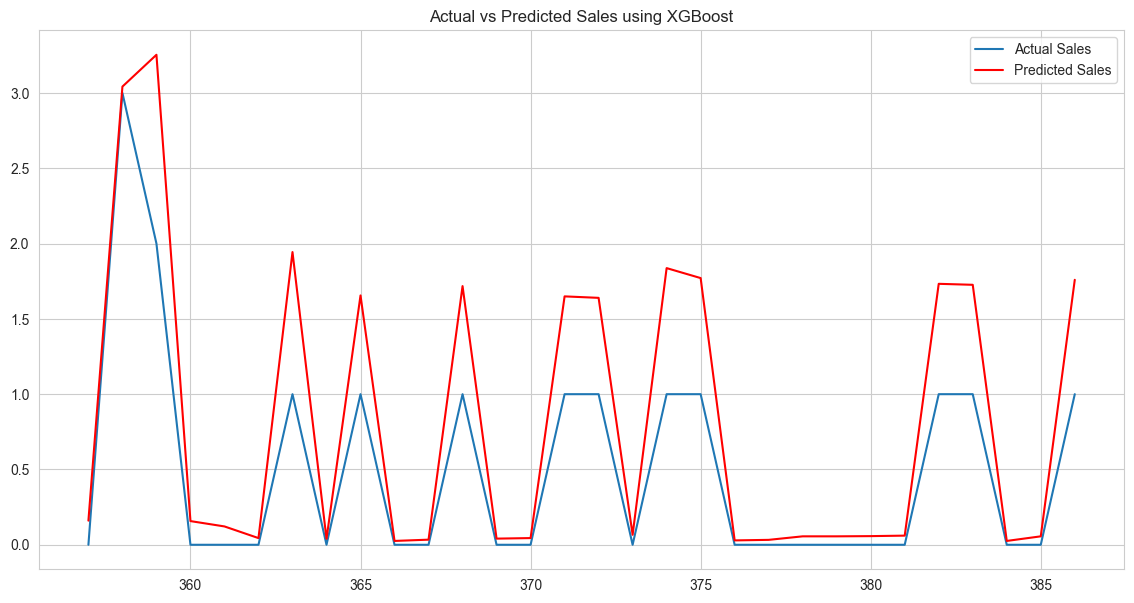

In [178]:
# Zoom window
w_start = 0
w_end = w_start + 30

plt.figure(figsize=(14, 7))
plt.plot(y_test.index[w_start:w_end], y_test.values[w_start:w_end], label='Actual Sales')
plt.plot(y_test.index[w_start:w_end], y_pred[w_start:w_end], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

## Model Evaluation

We will compare MAE, Bias, Mean Absolute Deviation (MAD), Relative Mean Absolute Deviation (RMAE), Mean absolute percentage error (MAPE), and Root Mean Square Error (RMSE).

In [179]:
def xgboost_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float).flatten()
    y_pred = np.asarray(y_pred, dtype=float).flatten()

    # basic errors
    errors       = y_true - y_pred
    abs_errors   = np.abs(errors)
    pct_errors   = abs_errors / np.where(y_true == 0, np.nan, y_true)   # avoid ÷0

    # core statistics
    mae   = abs_errors.mean()
    bias  = errors.mean()
    rmse  = np.sqrt((errors ** 2).mean())

    # MAD of the ACTUAL series (dispersion of demand itself)
    mad   = np.abs(y_true - y_true.mean()).mean()

    # Relative MAD = MAE divided by MAD  (how big the forecast error is vs. “typical” variation)
    rmad  = mae / mad if mad else np.nan

    # Mean Absolute Percentage Error
    mape  = np.nanmean(pct_errors) * 100   # expressed in %

    return {
        "MAE" : mae,
        "Bias": bias,
        "MAD" : mad,
        "rMAD": rmad,
        "MAPE": mape,
        "RMSE": rmse
    }

metrics = xgboost_metrics(y_test, y_pred)

for key, value in metrics.items():
    print(f"{key}: {value:.2f}")

MAE: 2.13
Bias: -0.68
MAD: 5.26
rMAD: 0.41
MAPE: 82.58
RMSE: 7.45


**Analysis**:

* **MAE**:
    * On average, the prediciton error is more than 2 sales units above the actual sales value.
        * This indicates the current model is overpredicting and should be optimized.
* **Bias**:
    * A bias of *-0.68* confirms that the current model is overpredicting.
* **MAD**:
    * The median forecast deviation with 5.26 units is higher than our mean error of 2.13.
        * This indicates that we have some outliers.
* **RMAD**:
    * The relative forecast deviation error tells us that the MAD deviates around 40% from the actual value.
* **MAPE**:
    * A mean absolute percentage error of 82% tells us, that the current model has a very low accuracy.
* **RMSE**:
    * The root mean square error of 7.45 confirms that our model made significant errors in predicting the demand.

## Hyperparameter Tuning

In [181]:
xgboost = xgb.XGBRegressor(objective='reg:squarederror')

### Define Parameter Grid

In [182]:
parameters = {
    'eta': [0.01, 0.1, 0.3],                    # Learning rate - smaller is safer but slower
    'max_depth': [3, 5, 7, 10],                 # max depth of each tree - control model complexity
    'subsample': [0.6, 0.7, 0.8, 1.0],          # fraction per boosting round - control over-fitting
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],   # fraction of features per tree - control over-fitting
    'n_estimators': [500, 600, 700, 800, 1000]  # number of boosting rounds
}

### Set up cross validation

In [183]:
tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=xgboost,
    param_distributions=parameters,
    cv=tscv, n_iter=10,
    scoring='neg_mean_absolute_error'
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_

print("Best Parameters for XGBoost:", best_params)

Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 5, 'eta': 0.01, 'colsample_bytree': 0.7}


### Retrain Model with Best Parameters

In [184]:
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eta=best_params['eta'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    n_estimators=best_params['n_estimators'],
    enable_categorical=True
)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

In [185]:
metrics = xgboost_metrics(y_test, y_pred)

for key, value in metrics.items():
    print(f"{key}: {value:.2f}")

MAE: 2.02
Bias: -0.33
MAD: 5.26
rMAD: 0.38
MAPE: 77.35
RMSE: 6.05


**Analysis**:

* **MAE**:
    * Dropped from 2.13 to 2.02. While this is a slight improvement, the model is still overpredicting.
* **Bias**:
    * Dropped from -0.68 to -0.33. This confirms we are still overpredicting, but less than before.
* **RMAD**:
    * The relative forecast deviation error dropped a little bit. Our relative median accuracy improved a little bit.
* **MAPE**:
    * From 82% to 77%. Still a very low accuracy, but slightly improved.
* **RMSE**:
    * From 7.45 to 6.05. The model made fewer errors in predicting the demand.

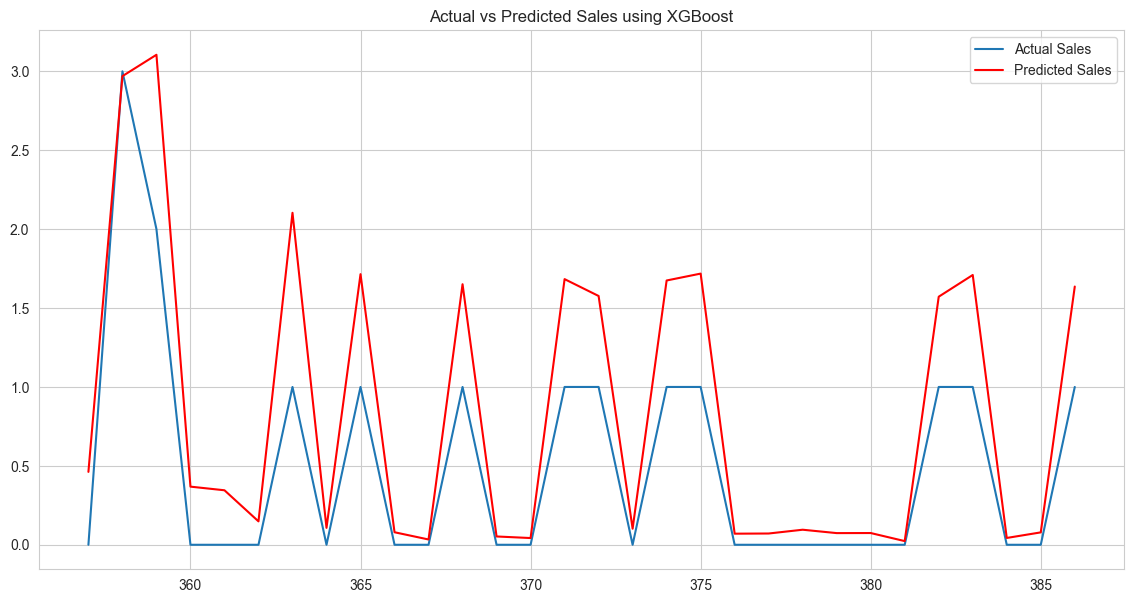

In [186]:
# Zoom window
w_start = 0
w_end = w_start + 30

plt.figure(figsize=(14, 7))
plt.plot(y_test.index[w_start:w_end], y_test.values[w_start:w_end], label='Actual Sales')
plt.plot(y_test.index[w_start:w_end], y_pred[w_start:w_end], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

## Save Model

In [188]:
with open('../resources/3_xgboost_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)